# Figures

In this notebook, we create the figures for aging datasets (murine and human): 

* Figure 1: 
* Figure S1
* Figure S2
* Figure S3
* Figure S4

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import scanpy.external as sce
import tqdm
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.sparse import csr_matrix
import os
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu
import statsmodels.api as sm

## Function: scatter plot old vs young

In [2]:
def scatterplot_young_old(ax, adata, title):
    """
    Takes annData object, the age group annotations for the young and the old categories 
    (as they appear in annData.obs), and a fraction of genes. The fraction of genes will be used
    to select the genes with the most extreme length values. For example, if fraction=0.3, it
    will select genes with a length below the percentile 0.3 and above the percentile 0.7. 
    It then creates a scatter plot with the mean gene expression of the selected genes, colored 
    according to their category (longest and shortest). It fits a straight to the mean expression 
    of the longest and the shortest genes seperately and the two straights are plotted as well.
    """

    if ax is None:
        ax = plt.gca()
        
    # Create young and old annDatas
    adata_young = adata[adata.obs['age'] == 'young']
    adata_old = adata[adata.obs['age'] == 'old']
    
    # Regress mean_expr_old from mean_expr_young
    x = adata_young.X.mean(axis=0).A1.reshape((-1, 1))
    y = adata_old.X.mean(axis=0).A1


    scatter = ax.scatter(x, y, s=0.3, color='#063b6883')

    ### Fit line using only short and only long genes ###
    m = LinearRegression(fit_intercept=False).fit(x, y)

    r = round(m.score(x, y), 2)
    slope = m.coef_
    intercept = m.intercept_
    
    x = np.linspace(0, max(x), 100)
    y = intercept + slope*x
    
    # Plot straight line
    ax.plot(x, y, color='#002c52a1',linestyle='dashed', linewidth=2, 
            label=f'r={r}')
    # Plot x=y
    ax.plot([0,max(x)],[0,max(x)], color='grey', linewidth=0.5, label='y = x')
    # ax.legend()

    ax.set_title(title, fontsize=12, wrap=True)
    
    n = len(set(adata.obs['batch']))
    N =  adata.shape[0]
    
    textstr = '\n'.join((
    r'$R^{2}=%.2f$' % (r, ),
    # r'$\beta=%.2f$' % (slope, ),
    r'$n=%.0f$' % (n, ),
    r'$N=%.0f$' % (N, )))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5, linewidth=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
    return scatter

## Function: Scatterplot length

In [3]:
def get_transcript_length_quantile(adata, lower_bound, upper_bound, length_type): 
    """
    Takes annData object and lower and upper bounds and returns the names of the genes
    whose transcript (longest, shortest or mean) length is above the lower_bound 
    percenile and below the upper_bound percentile. 
    """
    lower, upper = stats.mstats.mquantiles(adata.var[length_type].dropna(), [lower_bound, upper_bound])
    return adata[:, (adata.var[length_type] > lower) & (adata.var[length_type] <= upper)].var_names

In [4]:
def scatterplot_young_old_length(ax, adata, title,  beta_short, beta_long):
    """
    Takes annData object, the age group annotations for the young and the old categories 
    (as they appear in annData.obs), and a fraction of genes. The fraction of genes will be used
    to select the genes with the most extreme transcript length values. For example, if 
    fraction=0.3, it will select genes with a transcript length below the percentile 0.3 and above 
    the percentile 0.7. It then creates a scatter plot with the mean gene expression of the selected genes, colored 
    according to their category (longest and shortest). It fits a straight to the mean expression 
    of the longest and the shortest genes seperately and the two straights are plotted as well.
    """
    
    # We use these default values in the figure:
    length_type='gene_length'
    fraction= 0.25
    
    if ax is None:
        ax = plt.gca()
        
    # Create young and old annDatas
    adata_young = adata[adata.obs['age'] == 'young']
    adata_old = adata[adata.obs['age'] == 'old']
    
    ### Select fraction of longest and shortest genes ###

    # short genes
    shortest = get_transcript_length_quantile(adata, 0, fraction, length_type)
    x_short = adata_young[:, shortest].X.mean(axis=0).A1.reshape((-1, 1))
    y_short = adata_old[:, shortest].X.mean(axis=0).A1

    # long genes
    longest = get_transcript_length_quantile(adata, 1 - fraction, 1, length_type)
    x_long = np.array(adata_young[:, longest].X.mean(axis=0).ravel().tolist()[0]).reshape((-1, 1))
    y_long = np.array(adata_old[:, longest].X.mean(axis=0).ravel().tolist()[0])
    
    ax.scatter(x_short, y_short, s=1, color='#FFA500')
    ax.scatter(x_long, y_long, s=1, color='#3A5BA0')
        
    max_x = max([max(x_short),  max(x_long)])    
    x = np.linspace(0, max_x, 100)
    
    y_short = beta_short*x
    y_long =  beta_long*x
    
 
    beta_short, beta_long = '{:.2f}'.format(beta_short), '{:.2f}'.format(beta_long)
    
    beta_short_str = '$\u03B2_{s}$'
    beta_long_str = '$\u03B2_{l}$'
    
    ax.plot(x, y_short, color='#FFA500',linestyle='dashed', 
            label=f'{beta_short_str}={beta_short}')
    ax.plot(x, y_long, color='#3A5BA0', linestyle='dashed', 
            label=f'{beta_long_str}={beta_long}')
    
    ax.plot([0,max_x],[0,max_x], color='grey', linewidth=1)
    ax.legend(fontsize=8)
    
    ax.set_title(title, fontsize=12, wrap=True)
    
    n_y = len(set(adata[adata.obs['age']=='young'].obs['batch']))
    n_o = len(set(adata[adata.obs['age']=='old'].obs['batch']))
    
    # Text box: 
    textstr = '\n'.join((
    r'$n_{y}=%.0f$' % (n_y, ),
    r'$n_{o}=%.0f$' % (n_o, )))

    props = dict(boxstyle='round', facecolor='white', alpha=0.5, linewidth=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.7, 0.3, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)

In [5]:
def plot_scatter_and_linear_fit_fraction_simplified(adata, dset, fraction, length_type, condition_1, condition_2, beta_short=None, beta_long=None):
    """
    Takes annData object, the annotations for the two conditions
    (as they appear in annData.obs), and a fraction of genes. The fraction of genes will be used
    to select the genes with the most extreme transcript length values. For example, if 
    fraction=0.3, it will select genes with a transcript length below the percentile 0.3 and above 
    the percentile 0.7. It then creates a scatter plot with the mean gene expression of the selected genes, 
    colored  according to their category (longest and shortest). It fits a straight to the mean expression 
    of the longest and the shortest genes seperately and the two straights are plotted as well.
    """

    
    # Create young and old annDatas
    adata_cond1 = adata[adata.obs['condition'] == condition_1]
    adata_cond2 = adata[adata.obs['condition'] == condition_2]
    print(adata_cond1.shape, adata_cond2.shape)
    ### Select fraction of longest and shortest genes ###
    
    # short genes
    shortest = get_transcript_length_quantile(adata, 0, fraction, length_type)
    if type(adata.X) in [anndata._core.views.SparseCSRView, scipy.sparse.csr.csr_matrix]:
        x_short = adata_cond1[:, shortest].X.mean(axis=0).A1.reshape((-1, 1))
        y_short = adata_cond2[:, shortest].X.mean(axis=0).A1
    else:
        x_short = adata_cond1[:, shortest].X.mean(axis=0).reshape((-1, 1))
        y_short = adata_cond2[:, shortest].X.mean(axis=0)
        

    # long genes
    longest = get_transcript_length_quantile(adata, 1 - fraction, 1, length_type)
    if type(adata.X) in [anndata._core.views.SparseCSRView, scipy.sparse.csr.csr_matrix]:
        x_long = adata_cond1[:, longest].X.mean(axis=0).A1.reshape((-1, 1))
        y_long = adata_cond2[:, longest].X.mean(axis=0).A1
    else: 
        x_long = adata_cond1[:, longest].X.mean(axis=0).reshape((-1, 1))
        y_long = adata_cond2[:, longest].X.mean(axis=0)

    
    fig, ax = plt.subplots(1, 1, figsize=(3,3))

    ax.scatter(x_short, y_short, s=1, color='#FFA500')
    ax.scatter(x_long, y_long, s=1, color='#3A5BA0')
    
    ax.set_xlabel(f'Mean expression in {condition_1}')
    ax.set_ylabel(f'Mean expression in {condition_2}')

    ### Fit line using only short and only long genes ###
    m_short = LinearRegression(fit_intercept=False).fit(x_short, y_short)
    m_long = LinearRegression(fit_intercept=False).fit(x_long, y_long)

    slope_short, slope_long = m_short.coef_[0], m_long.coef_[0]
    intercept_short, intercept_long = m_short.intercept_, m_long.intercept_
    
    # If slopes are given (taken from R analysis), use those
    if not (beta_short is None and beta_long is None):
        print('right betas')
        slope_short = beta_short
        slope_long = beta_long
        
    max_x = max([max(x_short),  max(x_long)])    
    x = np.linspace(0, max_x, 100)
    
    y_short = intercept_short + slope_short*x
    y_long = intercept_long + slope_long*x
    
    slope_short, slope_long = '{:.2f}'.format(slope_short), '{:.2f}'.format(slope_long)
    intercept_short, intercept_long = '{:.2f}'.format(intercept_short), '{:.2f}'.format(intercept_long)
    
    beta_short = '$\u03B2_{s}$'
    beta_long = '$\u03B2_{l}$'

    ax.plot(x, y_short, color='#FFA500',linestyle='dashed', 
            label=f'{beta_short}={slope_short}')
    
    
    ax.plot(x, y_long, color='#3A5BA0', linestyle='dashed', 
            label=f'{beta_long}={slope_long}')
    
    ax.plot([0,max_x],[0,max_x], color='grey', linewidth=1)
    plt.legend()
    plt.axis('off')
    plt.savefig(f'./../output/figs/non_aging/{dset}/scatterplot_regression/png/{dset}_fraction{fraction}_{condition_1}_{condition_2}.png',dpi=300, bbox_inches = 'tight')
    plt.savefig(f'./../output/figs/non_aging/{dset}/scatterplot_regression/svg/{dset}_fraction{fraction}_{condition_1}_{condition_2}.svg')

## Get young vs old DEGS

In [46]:
def get_DEG_df(adata, n):
    
    adata = adata[adata.obs['age'].isin(['young', 'old'])]
    sc.tl.rank_genes_groups(adata, groupby='age', method='wilcoxon', use_raw=False)
    groups = adata.uns['rank_genes_groups']['names'].dtype.names
    DEGs = pd.DataFrame(
    {group + '_' + key[:1]: adata.uns['rank_genes_groups'][key][group]
     
    for group in groups for key in ['names', 'logfoldchanges', 'pvals']})
    young_degs = DEGs.loc[0:n,['young_n', 'young_l']].set_index('young_n')
    old_degs = DEGs.loc[0:n,['old_n', 'old_l']].set_index('old_n')
    
    young_degs.loc[:, 'overexpressed'] = 'young'
    old_degs.loc[:, 'overexpressed'] = 'old'
    
    young_degs.rename(columns={'young_l':'logFC', f'young_n': 'Gene'}, inplace=True)
    old_degs.rename(columns={'old_l':'logFC', 'old_n': 'Gene'}, inplace=True)
    DEG_df = pd.concat([young_degs, old_degs], axis=0)
    DEG_df.loc[:, 'gene_length'] = [adata.var.loc[gene]['gene_length'] 
                                    if gene in adata.var.index else np.nan 
                                    for gene in DEG_df.index]
    return DEG_df

## Function: make boxplot

In [58]:
palette_dim = ['#c9d8e1ff', '#d4a8c4ff']
palette_bold = ['#557e96ff', '#7C3E66']
def boxplot_length_young_old(ax, title, DEG_df): 
    """
    Plot gene length against logFC of DEGs between young and old 
    """
    if ax is None:
        ax = plt.gca()
    adata.obs['age'] = adata.obs['age'].cat.reorder_categories(['young', 'old'])
        
    bp = sns.boxplot(ax=ax, data=DEG_df, x='overexpressed', y='gene_length', 
              order=['young', 'old'], palette=palette_dim, linewidth=0.5, fliersize=0)
    sp = sns.stripplot(ax=ax, data=DEG_df, x='overexpressed', y='gene_length', s=1.5,
              order=['young', 'old'],
              palette=palette_bold)
    bp.set_yscale('log')
    sp.set_yscale('log')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax.set_title(title, fontsize=12, wrap=True)

## Function: get annData

In [8]:
def get_anndata(path2anndata): 
    adata = sc.read(path2anndata+ '.h5ad')
    adata = adata[:, adata.X.mean(axis=0) > 0.1]
    return adata

# Figure 1
TMS FACS (TMSF) and TMS Droplet (TMSD) datasets: male mice aged 3months and 24 months.

In [61]:
paths = np.array(os.listdir('../data/annDatas_balanced/'))
metadata = pd.read_csv('../output/tables/aging_datasets_metadata.csv', sep=',', index_col=0)
metadata = metadata[metadata.include == 'fig1']
metadata.shape

(12, 8)

## A: scatter plot: old vs young

In [62]:
paths = np.array(['../data/annDatas_balanced/' + dset_name for dset_name in metadata.index])
titles = np.array([title.capitalize() for title in metadata.loc[:, 'tissue']])

In [63]:
# Alphabetical order
paths = paths[np.argsort(titles)]
titles = titles[np.argsort(titles)]

In [64]:
paths = paths.reshape((3, 4))
titles = titles.reshape((3, 4))

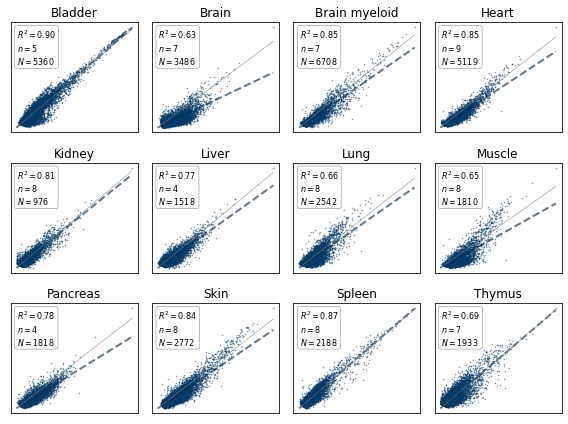

In [65]:
n_row = paths.shape[0]
n_col = paths.shape[1]
fig, axs = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))
for i in range(n_row):
    for j in range(n_col):
        adata = get_anndata(paths[i][j])
        scatterplot_young_old(axs[i][j], adata, titles[i][j])
        axs[i][j].xaxis.set_ticks([])
        axs[i][j].yaxis.set_ticks([])
    plt.tight_layout()
plt.savefig('../output/figs/article_figures/figure_1a.png', dpi=300)
plt.savefig('../output/figs/article_figures/figure_1a.svg')

## B: Scatter plot with gene length

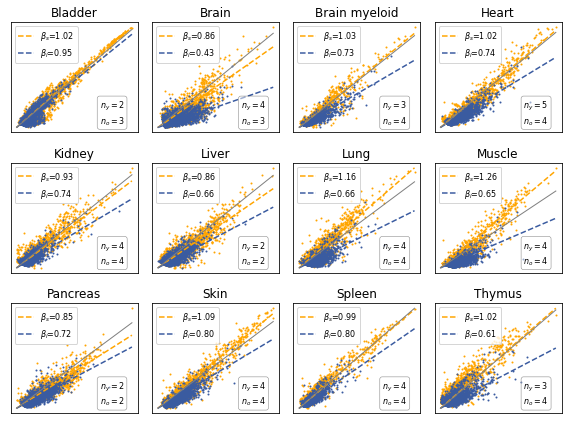

In [66]:
n_row = paths.shape[0]
n_col = paths.shape[1]
fig, axs = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))
for i in range(n_row):
    for j in range(n_col):
        adata = get_anndata(paths[i][j])
        R_output = pd.read_csv(f'../output/tables/regression_R/{titles[i][j]}_young_old.csv', sep=' ', index_col=0)
        beta_short = R_output.loc['GazteME', 'Estimate']
        beta_long = beta_short + R_output.loc['GazteME:LuzeKATQ4', 'Estimate']
        scatterplot_young_old_length(axs[i][j], adata, titles[i][j], beta_short, beta_long)
        axs[i][j].xaxis.set_ticks([])
        axs[i][j].yaxis.set_ticks([])
plt.tight_layout()
plt.savefig('../output/figs/article_figures/Figure_1/figure_1B.png', dpi=300)
plt.savefig('../output/figs/article_figures/Figure_1/figure_1B.svg')

# Figure S1

In [67]:
paths = np.array(os.listdir('../data/annDatas_balanced/'))
metadata = pd.read_csv('../output/tables/aging_datasets_metadata.csv', sep=',', index_col=0)
metadata = metadata[metadata.include == 'fig_s1']
metadata.shape

(10, 8)

## A: scatter plot: old vs young

In [73]:
paths = np.array(['../data/annDatas_balanced/' + dset_name for dset_name in metadata.index])
titles = np.array([title.split('/')[0] for title in metadata.loc[:, 'dset_name_str']])

In [74]:
titles

array(['Ximerakis brain', 'Angelidis lung', 'Kimmel lung',
       'Kimmel spleen', 'Kimmel kidney', 'Sole-Boldo skin',
       'Travaglini lung', 'Raredon lung', 'Enge pancreas',
       'Salzer fibroblasts'], dtype='<U18')

In [75]:
titles = np.array(['Angelidis lung', 'Kimmel lung', 'Kimmel kidney', 'Kimmel spleen', 'Ximerakis brain', 'Salzer fibroblasts', 
                  '', '','Travaglini lung', 'Raredon lung', 'Enge pancreas', 'Sole-Boldo skin'])

In [76]:
paths = np.array(['../data/annDatas_balanced/Angelidis_lung_3_24',
                  '../data/annDatas_balanced/Kimmel_lung_male_7_21',
                  '../data/annDatas_balanced/Kimmel_kidney_male_7_21',
                  '../data/annDatas_balanced/Kimmel_spleen_male_7_21',
                  '../data/annDatas_balanced/Ximerakis_male_2_22',
                  '../data/annDatas_balanced/Salzer_fibroblasts_female_2_18',
                  '', 
                  '', 
                  '../data/annDatas_balanced/Travaglini_lung_male_46_75',
                  '../data/annDatas_balanced/Raredon_lung_mixed_27_73',
                  '../data/annDatas_balanced/Enge_pancreas_mixed_22_49',
                  '../data/annDatas_balanced/SoleBoldo_skin_male_26_62'])

In [77]:
paths = paths.reshape((3, 4))
titles = titles.reshape((3, 4))

/home/olga/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['triku_params']['None']['knn_array'] that happens to be dimensioned at n_obs×n_obs (22142×22142).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(


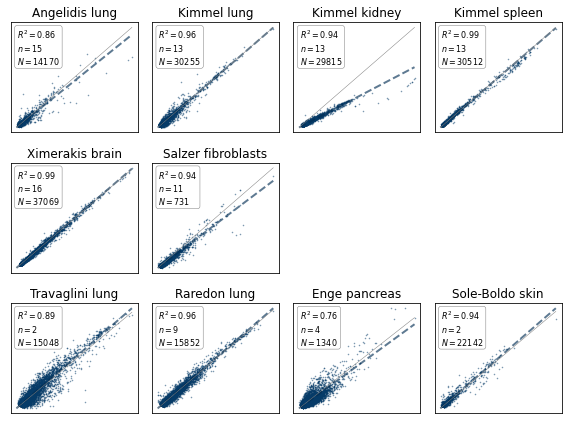

In [78]:
n_row = paths.shape[0]
n_col = paths.shape[1]
fig, axs = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))
for i in range(n_row):
    for j in range(n_col):
        title = titles[i][j]
        if title != '':
            adata = get_anndata(paths[i][j])
            scatterplot_young_old(axs[i][j], adata, title)
            axs[i][j].xaxis.set_ticks([])
            axs[i][j].yaxis.set_ticks([])
        else: 
            axs[i][j].set_visible(False)
    plt.tight_layout()
plt.savefig('../output/figs/article_figures/Figure_S1/figure_1SA.png', dpi=300)
plt.savefig('../output/figs/article_figures/Figure_S1/figure_1SA.svg')

## B: Scatter plot with gene length

/home/olga/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['triku_params']['None']['knn_array'] that happens to be dimensioned at n_obs×n_obs (22142×22142).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/olga/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['triku_params']['None']['knn_array'] that happens to be dimensioned at n_obs×n_obs (22142×22142).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/olga/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, found matrix at .uns['triku_params']['None']['knn_array'] that happens to be dimensioned at n_obs×n_obs (22142×22142).

These matrices should now be stored in the .o

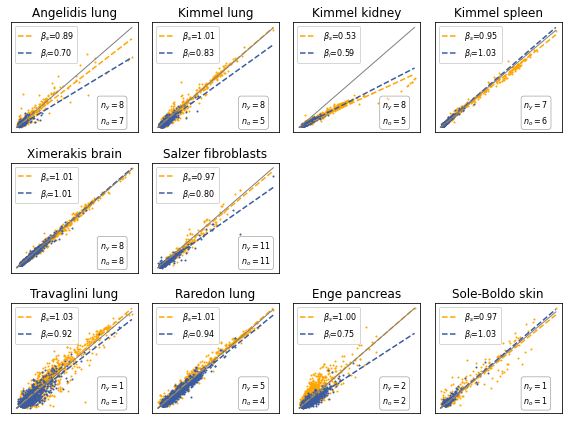

In [79]:
n_row = paths.shape[0]
n_col = paths.shape[1]
fig, axs = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))
for i in range(n_row):
    for j in range(n_col):
        title = titles[i][j]
        if title != '': 
            adata = get_anndata(paths[i][j])
            R_output = pd.read_csv(f'../output/tables/regression_R/{title}_young_old.csv', sep=' ', index_col=0)
            beta_short = R_output.loc['GazteME', 'Estimate']
            beta_long = beta_short + R_output.loc['GazteME:LuzeKATQ4', 'Estimate']
            scatterplot_young_old_length(axs[i][j], adata, title, beta_short, beta_long)
            axs[i][j].xaxis.set_ticks([])
            axs[i][j].yaxis.set_ticks([])
        else: 
            axs[i][j].set_visible(False)
plt.tight_layout()
plt.savefig('../output/figs/article_figures/Figure_S1/figure_1SB.png', dpi=300)
plt.savefig('../output/figs/article_figures/Figure_S1/figure_1SB.svg')

# Figure S2

In [80]:
paths = np.array(os.listdir('../data/annDatas_balanced/'))
metadata = pd.read_csv('../output/tables/aging_datasets_metadata.csv', sep=',', index_col=0)
metadata = metadata[metadata.include == 'fig_s2']
metadata.shape

(12, 8)

## A: scatter plot: old vs young

In [81]:
paths = np.array(['../data/annDatas_balanced/' + dset_name for dset_name in metadata.index])
titles = np.array([title.split('/')[0] for title in metadata.loc[:, 'dset_name_str']])

In [82]:
paths = paths.reshape((3, 4))
titles = titles.reshape((3, 4))

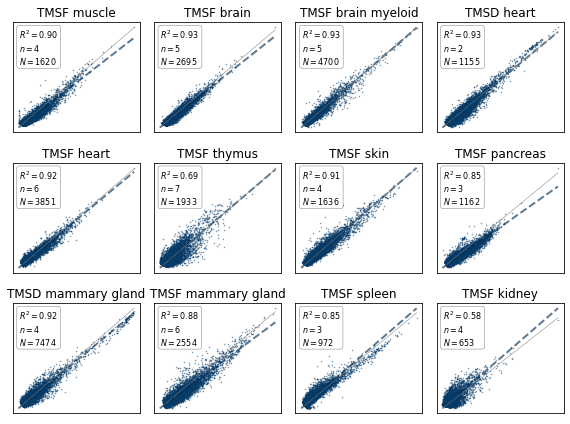

In [83]:
n_row = paths.shape[0]
n_col = paths.shape[1]
fig, axs = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))
for i in range(n_row):
    for j in range(n_col):
        adata = get_anndata(paths[i][j])
        scatterplot_young_old(axs[i][j], adata, titles[i][j])
        axs[i][j].xaxis.set_ticks([])
        axs[i][j].yaxis.set_ticks([])
    plt.tight_layout()
plt.savefig('../output/figs/article_figures/Figure_S2/figure_S2A.png', dpi=300)
plt.savefig('../output/figs/article_figures/Figure_S2/figure_S2A.svg')

## B: Scatter plot with gene length

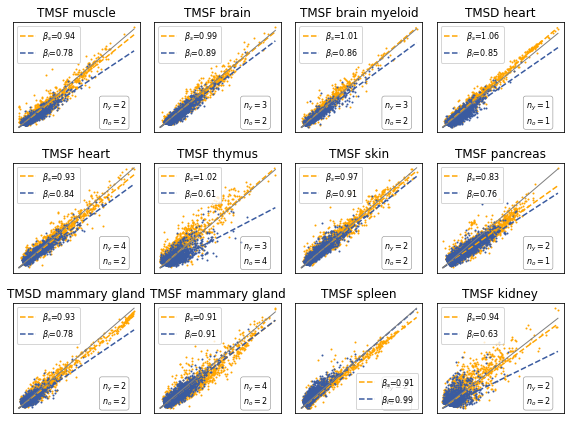

In [84]:
n_row = paths.shape[0]
n_col = paths.shape[1]
fig, axs = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))
for i in range(n_row):
    for j in range(n_col):
        adata = get_anndata(paths[i][j])
        R_output = pd.read_csv(f'../output/tables/regression_R/{titles[i][j]}_young_old.csv', sep=' ', index_col=0)
        beta_short = R_output.loc['GazteME', 'Estimate']
        beta_long = beta_short + R_output.loc['GazteME:LuzeKATQ4', 'Estimate']
        scatterplot_young_old_length(axs[i][j], adata, titles[i][j], beta_short, beta_long)
        axs[i][j].xaxis.set_ticks([])
        axs[i][j].yaxis.set_ticks([])
plt.tight_layout()
plt.savefig('../output/figs/article_figures/Figure_S2/figure_S2B.png', dpi=300)
plt.savefig('../output/figs/article_figures/Figure_S2/figure_S2B.svg')

# Figure 2
Same datasets as in Figure 1 in the same order. But now we show the length of the DEGs between young and old cells. 

In [59]:
paths = np.array(os.listdir('../data/annDatas_balanced/'))
metadata = pd.read_csv('../output/tables/aging_datasets_metadata.csv', sep=',', index_col=0)
metadata = metadata[metadata.include == 'fig1']
metadata.shape

(12, 8)

## Boxplot

In [60]:
paths = np.array(['../data/annDatas_balanced/' + dset_name for dset_name in metadata.index])
titles = np.array([title.capitalize() for title in metadata.loc[:, 'tissue']])

In [61]:
# Alphabetical order
paths = paths[np.argsort(titles)]
titles = titles[np.argsort(titles)]

In [62]:
paths = paths.reshape((3, 4))
titles = titles.reshape((3, 4))

../data/annDatas_balanced/TMS_droplet_bladder_male_3_24


Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.


../data/annDatas_balanced/TMS_FACS_brain_non_myeloid_male_3_24


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.


../data/annDatas_balanced/TMS_FACS_brain_myeloid_male_3_24


Trying to set attribute `.obs` of view, copying.


../data/annDatas_balanced/TMS_FACS_heart_male_3_24


Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.


../data/annDatas_balanced/TMS_FACS_kidney_male_3_24


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.


../data/annDatas_balanced/TMS_FACS_liver_male_3_24


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.


../data/annDatas_balanced/TMS_FACS_lung_male_3_24


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.


../data/annDatas_balanced/TMS_FACS_muscle_male_3_24


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.


../data/annDatas_balanced/TMS_FACS_pancreas_male_3_24


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.


../data/annDatas_balanced/TMS_FACS_skin_male_3_24


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.


../data/annDatas_balanced/TMS_FACS_spleen_male_3_24


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.


../data/annDatas_balanced/TMS_FACS_thymus_male_3_24


Trying to set attribute `.obs` of view, copying.


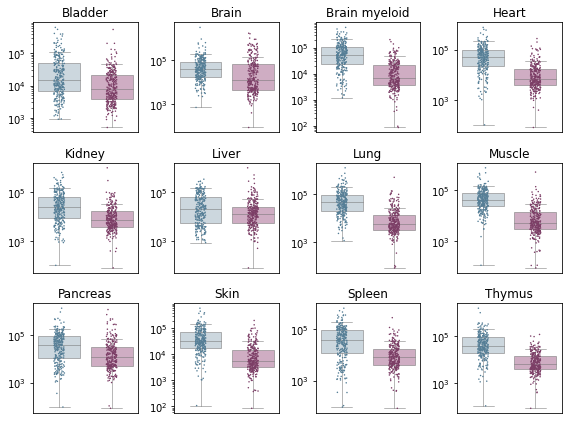

In [73]:
n_row = paths.shape[0]
n_col = paths.shape[1]
fig, axs = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))
for i in range(n_row):
    for j in range(n_col):
        print(paths[i][j])
        adata = get_anndata(paths[i][j])
        DEG_df = get_DEG_df(adata, 300)
        DEG_df.dropna(inplace=True)
        boxplot_length_young_old(axs[i][j], titles[i][j], DEG_df)
        axs[i][j].xaxis.set_ticks([])
        # axs[i][j].yaxis.set_ticks([])
plt.tight_layout()
plt.savefig('../output/figs/article_figures/Figure_2/figure_2.png', dpi=300)
plt.savefig('../output/figs/article_figures/Figure_2/figure_2.svg')

## Figure 2: statistical analysis

In [84]:
def test_normality(df_genes): 
    young_length = df_genes[df_genes.loc[:, 'overexpressed'] == 'young'].loc[:, 'gene_length'].values
    old_length = df_genes[df_genes.loc[:, 'overexpressed'] == 'old'].loc[:, 'gene_length'].values
    print('Number of DEGs (young):', len(young_length))
    print('Number of DEGs (old):', len(old_length))
    stat_young, pval_young = sm.stats.diagnostic.lilliefors(np.log10(young_length), dist='norm', pvalmethod='table')
    stat_old, pval_old = sm.stats.diagnostic.lilliefors(np.log10(old_length), dist='norm', pvalmethod='table')
    for cond in ['young', 'old']: 
        stat, pval = eval(f'stat_{cond}'), eval(f'pval_{cond}')
        if pval < 0.05: 
            output = 'NOT normally distributed'
        else: 
            output = 'Normally distributed'
        print(f'Condition: {cond}\nStat: {stat} \np-value: {pval}\n' + output + '\n' + 30*'-')

In [91]:
def mann_whitney(df_genes): 
    young_length = df_genes[df_genes.loc[:, 'overexpressed'] == 'young'].loc[:, 'gene_length'].values
    old_length = df_genes[df_genes.loc[:, 'overexpressed'] == 'old'].loc[:, 'gene_length'].values
    stat, pval = mannwhitneyu(np.log10(young_length), np.log10(old_length))
    if pval < 0.001:
        output = 'Significant difference (p-value < 0.001'
    else: 
        output = 'Not significant'
    print(f'Stat: {stat}\np-value: {pval}\n{output}')
    return stat, pval

In [86]:
n_row = paths.shape[0]
n_col = paths.shape[1]
for i in range(n_row):
    for j in range(n_col):
        print(titles[i][j])
        adata = get_anndata(paths[i][j])
        DEG_df = get_DEG_df(adata, 300)
        DEG_df.dropna(inplace=True)
        test_normality(DEG_df)

Bladder


Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


Number of DEGs (young): 285
Number of DEGs (old): 288
Condition: young
Stat: 0.06680279410977613 
p-value: 0.007092680122442977
NOT normally distributed
------------------------------
Condition: old
Stat: 0.08535030849727637 
p-value: 0.0009999999999998899
NOT normally distributed
------------------------------
Brain
Number of DEGs (young): 278
Number of DEGs (old): 283
Condition: young
Stat: 0.032813909460056134 
p-value: 0.7362689240461979
Normally distributed
------------------------------
Condition: old
Stat: 0.10138869950133744 
p-value: 0.0009999999999998899
NOT normally distributed
------------------------------
Brain myeloid


Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


Number of DEGs (young): 284
Number of DEGs (old): 280
Condition: young
Stat: 0.08399625933405147 
p-value: 0.0009999999999998899
NOT normally distributed
------------------------------
Condition: old
Stat: 0.07397124313328318 
p-value: 0.0019995096303427446
NOT normally distributed
------------------------------
Heart


Trying to set attribute `.uns` of view, copying.


Number of DEGs (young): 273
Number of DEGs (old): 282
Condition: young
Stat: 0.09002713158723086 
p-value: 0.0009999999999998899
NOT normally distributed
------------------------------
Condition: old
Stat: 0.0720009578267774 
p-value: 0.002668161537616869
NOT normally distributed
------------------------------
Kidney


Trying to set attribute `.uns` of view, copying.


Number of DEGs (young): 283
Number of DEGs (old): 283
Condition: young
Stat: 0.03657524636225534 
p-value: 0.5526333165860904
Normally distributed
------------------------------
Condition: old
Stat: 0.05739615932492648 
p-value: 0.0400564074439854
NOT normally distributed
------------------------------
Liver


Trying to set attribute `.uns` of view, copying.


Number of DEGs (young): 274
Number of DEGs (old): 279
Condition: young
Stat: 0.0730613020627694 
p-value: 0.0026252773840249773
NOT normally distributed
------------------------------
Condition: old
Stat: 0.041376023727554334 
p-value: 0.3719850482487954
Normally distributed
------------------------------
Lung


Trying to set attribute `.uns` of view, copying.


Number of DEGs (young): 282
Number of DEGs (old): 287
Condition: young
Stat: 0.035425882617304394 
p-value: 0.607678813509407
Normally distributed
------------------------------
Condition: old
Stat: 0.07129480689727988 
p-value: 0.0027125267482394333
NOT normally distributed
------------------------------
Muscle


Trying to set attribute `.uns` of view, copying.


Number of DEGs (young): 283
Number of DEGs (old): 285
Condition: young
Stat: 0.05461922649383788 
p-value: 0.06083395117110287
Normally distributed
------------------------------
Condition: old
Stat: 0.07691437099147125 
p-value: 0.0009999999999998899
NOT normally distributed
------------------------------
Pancreas


Trying to set attribute `.uns` of view, copying.


Number of DEGs (young): 279
Number of DEGs (old): 273
Condition: young
Stat: 0.08100942117894627 
p-value: 0.0009999999999998899
NOT normally distributed
------------------------------
Condition: old
Stat: 0.06515218037699999 
p-value: 0.01253901091825877
NOT normally distributed
------------------------------
Skin


Trying to set attribute `.uns` of view, copying.


Number of DEGs (young): 286
Number of DEGs (old): 281
Condition: young
Stat: 0.06368121133736615 
p-value: 0.012829688926270894
NOT normally distributed
------------------------------
Condition: old
Stat: 0.08590255989234752 
p-value: 0.0009999999999998899
NOT normally distributed
------------------------------
Spleen


Trying to set attribute `.uns` of view, copying.


Number of DEGs (young): 278
Number of DEGs (old): 280
Condition: young
Stat: 0.09379189492018142 
p-value: 0.0009999999999998899
NOT normally distributed
------------------------------
Condition: old
Stat: 0.04861057346590293 
p-value: 0.1618312418719225
Normally distributed
------------------------------
Thymus
Number of DEGs (young): 281
Number of DEGs (old): 282
Condition: young
Stat: 0.06158724935634702 
p-value: 0.020584439579694476
NOT normally distributed
------------------------------
Condition: old
Stat: 0.07034844967624498 
p-value: 0.003632379206415469
NOT normally distributed
------------------------------


In [95]:
stats = pd.DataFrame(index=titles.ravel())
n_row = paths.shape[0]
n_col = paths.shape[1]
for i in range(n_row):
    for j in range(n_col):
        title = titles[i][j]
        print(title)
        adata = get_anndata(paths[i][j])
        DEG_df = get_DEG_df(adata, 300)
        DEG_df.dropna(inplace=True)
        stat, pval = mann_whitney(DEG_df)
        stats.loc[title, 'Statistic'] = stat
        stats.loc[title, 'p-value'] = pval

Bladder


Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


Stat: 28948.5
p-value: 5.23468399928034e-10
Significant difference (p-value < 0.001
Brain
Stat: 27401.0
p-value: 2.5184011829259344e-10
Significant difference (p-value < 0.001
Brain myeloid


Trying to set attribute `.uns` of view, copying.


Stat: 13075.0
p-value: 1.4490303416600767e-43
Significant difference (p-value < 0.001
Heart


Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


Stat: 12005.5
p-value: 5.537517654790282e-45
Significant difference (p-value < 0.001
Kidney


Trying to set attribute `.uns` of view, copying.


Stat: 22024.0
p-value: 9.907064001239285e-21
Significant difference (p-value < 0.001
Liver


Trying to set attribute `.uns` of view, copying.


Stat: 31636.0
p-value: 0.0002274396255704523
Significant difference (p-value < 0.001
Lung


Trying to set attribute `.uns` of view, copying.


Stat: 10844.0
p-value: 7.162110384063404e-52
Significant difference (p-value < 0.001
Muscle


Trying to set attribute `.uns` of view, copying.


Stat: 8774.5
p-value: 7.311847285848094e-59
Significant difference (p-value < 0.001
Pancreas


Trying to set attribute `.uns` of view, copying.


Stat: 25380.0
p-value: 5.995010465905342e-12
Significant difference (p-value < 0.001
Skin


Trying to set attribute `.uns` of view, copying.


Stat: 12953.5
p-value: 1.3508804723213027e-44
Significant difference (p-value < 0.001
Spleen


Trying to set attribute `.uns` of view, copying.


Stat: 19386.0
p-value: 5.446078188378311e-25
Significant difference (p-value < 0.001
Thymus
Stat: 10888.5
p-value: 1.969029822478746e-50
Significant difference (p-value < 0.001


In [97]:
stats.to_csv('../output/tables/latex_tables/Figure_2_DEGs_between_young_and_old_statistical_significance.csv')

In [75]:
DEG_df.head()

,logFC,overexpressed,gene_length
Satb1,2.397296,young,97103.0
Lars2,1.082725,young,95739.0
Rps29,1.515829,young,1464.0
Tcf7,1.597108,young,30960.0
Ets1,1.883007,young,121599.0


# Figure S3
Dowregulation of longer genes is found in several datasets of different species.

In [90]:
paths = np.array(['../data/annDatas_balanced/' + dset_name for dset_name in metadata.index])
titles = np.array([title.split('/')[0] for title in metadata.loc[:, 'dset_name_str']])

In [91]:
titles

array(['TMSF liver', 'TMSF muscle', 'TMSF brain', 'TMSF brain myeloid',
       'TMSF heart', 'TMSF thymus', 'TMSF skin', 'TMSD bladder',
       'TMSF lung', 'TMSF pancreas', 'TMSF spleen', 'TMSF kidney'],
      dtype='<U18')

In [92]:
titles = np.array(['Angelidis lung', 'Kimmel lung', 'Kimmel kidney', 'Kimmel spleen', 'Ximerakis brain', 'Salzer fibroblasts', 
                  '', '','Travaglini lung', 'Raredon lung', 'Enge pancreas', 'Sole-Boldo skin'])

In [93]:
paths = np.array(['../data/annDatas_balanced/Angelidis_lung_3_24',
                  '../data/annDatas_balanced/Kimmel_lung_male_7_21',
                  '../data/annDatas_balanced/Kimmel_kidney_male_7_21',
                  '../data/annDatas_balanced/Kimmel_spleen_male_7_21',
                  '../data/annDatas_balanced/Ximerakis_male_2_22',
                  '../data/annDatas_balanced/Salzer_fibroblasts_female_2_18',
                  '', 
                  '', 
                  '../data/annDatas_balanced/Travaglini_lung_male_46_75',
                  '../data/annDatas_balanced/Raredon_lung_mixed_27_73',
                  '../data/annDatas_balanced/Enge_pancreas_mixed_22_49',
                  '../data/annDatas_balanced/SoleBoldo_skin_male_26_62'])

In [94]:
paths = paths.reshape((3, 4))
titles = titles.reshape((3, 4))

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
/home/olga/.local/lib/python3.8/site-packages/anndata/compat/__init__.py:211: FutureWarning: During AnnData slicing, f

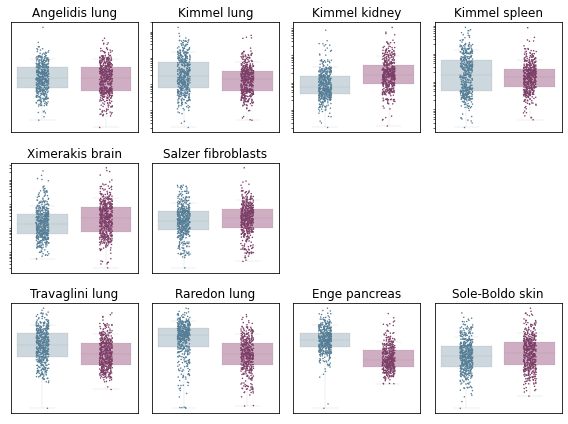

In [95]:
n_row = paths.shape[0]
n_col = paths.shape[1]
fig, axs = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))
for i in range(n_row):
    for j in range(n_col):
        title = titles[i][j]
        if title != '':
            adata = get_anndata(paths[i][j])
            DEG_df = get_DEG_df(adata, 500)
            boxplot_length_young_old(axs[i][j], titles[i][j], DEG_df)
            axs[i][j].xaxis.set_ticks([])
            axs[i][j].yaxis.set_ticks([])
        else: 
            axs[i][j].set_visible(False)
    plt.tight_layout()
plt.savefig('../output/figs/article_figures/Figure_S3/Figure_S3.png', dpi=300)
plt.savefig('../output/figs/article_figures/Figure_S3/Figure_S3.svg')

# Figure S4

In [96]:
paths = np.array(os.listdir('../data/annDatas_balanced/'))
metadata = pd.read_csv('../output/tables/aging_datasets_metadata.csv', sep=',', index_col=0)
metadata = metadata[metadata.include == 'fig_s2']
metadata.shape

(12, 8)

## A: scatter plot: old vs young

In [97]:
paths = np.array(['../data/annDatas_balanced/' + dset_name for dset_name in metadata.index])
titles = np.array([title.split('/')[0] for title in metadata.loc[:, 'dset_name_str']])

In [98]:
paths = paths.reshape((3, 4))
titles = titles.reshape((3, 4))

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

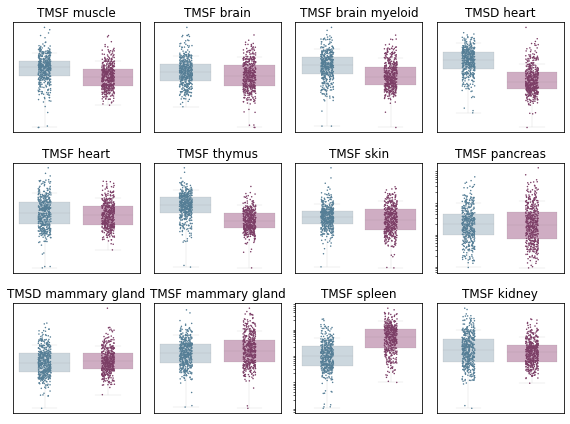

In [100]:
n_row = paths.shape[0]
n_col = paths.shape[1]
fig, axs = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))
for i in range(n_row):
    for j in range(n_col):
        adata = get_anndata(paths[i][j])
        DEG_df = get_DEG_df(adata, 500)
        boxplot_length_young_old(axs[i][j], titles[i][j], DEG_df)
        axs[i][j].xaxis.set_ticks([])
        axs[i][j].yaxis.set_ticks([])
    plt.tight_layout()
plt.savefig('../output/figs/article_figures/Figure_S4/figure_S4.png', dpi=300)
plt.savefig('../output/figs/article_figures/Figure_S4/figure_S4.svg')